$$

    f(a) = e^{-\int_0^a{(1+\epsilon(a, s))\mu(s) ds}}\\
    \mu(s) = \mu_{ub} - (\mu_{ub} - \mu_{lb})\frac{s^{m}}{s^{m} + K^{m}}

$$

$$
\epsilon(a, s) = 
\begin{cases}
    0 & \text{if } s < a - t_e \\
    g(a)e^{-\lambda(t_e-(a-s))} & \text{otherwise }
\end{cases}
$$

$$
\epsilon_0 e^{-\tau|a-t_e|}
$$

In [42]:
from firm_dynamics.survival_analysis import *
from firm_dynamics.hill import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

uen Sector  status           Exit Date          Entry Date Region  \
0   53376145W      N       0 2020-04-30 09:36:00 2018-01-13 10:32:56     NR   
1   53290857X      S       1                 NaT 2015-02-26 12:02:44     CR   
3  200412424K      G       1                 NaT 2004-09-28 17:56:29     WR   
4   53396472E      H       0 2020-10-10 09:36:00 2019-04-11 21:20:43     CR   
5   48376900B      S       0 1999-12-24 04:48:00 1993-04-12 00:00:00    NER   

         age  Dead  
0   4.963723     1  
1   7.843943     0  
3  18.255989     0  
4   3.723477     1  
5  29.722108     1

In [2]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
sector_params_MLE = dict(zip(sector_list, parameters))

In [38]:
def epsilon(s, a, eps0, tau, lam, t_e):
    '''
    Time-dependent perturbation function
    Inputs:
    - s: integration variable (time)
    - a: age
    - eps0: amplitude of the perturbation
    - tau: decay rate (against age of firm) of the effect of external event
    - lam: recovery rate (against time since event)
    - t_e: time of event causing the perturbation
    '''
    def g(a, eps0, tau, t_e):
        if a < t_e:
            return eps0
        else:
            return eps0 * np.exp(-abs(a - t_e) * tau)
    if s < a - t_e:
        return 0
    else:
        return g(a, eps0, tau, t_e)*np.exp(-lam*(t_e-(a-s)))

def hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)
    return hill_survival_function(a, mu_ub, mu_lb, K, m) * np.exp(-val)

def model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam):
    return np.array([hill_survival_with_dip(a, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam) for a in ages])

def find_dip(df_analysis, sector):
    '''
    Find the dip location for a given sector by finding points of minimum log-likelihood
    '''
    sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
    parameters = [
    [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212], 
    [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619], 
    [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219], 
    [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392], 
    [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189], 
    [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0], 
    [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0], 
    [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204], 
    [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744], 
    [0.12639658719104133, 1.0000000249470075e-10, 20.851108767628933, 3.8694205399833757], 
    [0.1212132957507885, 0.06868421106599219, 9.445203344625348, 100.0], 
    [0.07305173006148806, 0.07305173006148806, 4.686889369376459, 49.86003240187913], 
    [0.07830160011697058, 0.047197607271208426, 7.792050676547918, 100.0], 
    [0.13228889671445893, 0.0854858990969846, 8.857658026221204, 100.0]
    ]
    sector_params_MLE = dict(zip(sector_list, parameters))

    _, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    mu_ub, mu_lb, K, m = sector_params_MLE[sector]
    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = survivors * np.log(S_vals) + deaths * np.log(1 - S_vals)

    minlogL_ages = ages[np.argsort(logL)[:9]]
    max_count = 0
    best_cluster = []

    for i in range(len(minlogL_ages)):
        # Find all points within window of minlogL_ages[i]
        cluster = minlogL_ages[(minlogL_ages >= minlogL_ages[i]) & (minlogL_ages <= minlogL_ages[i] + 0.5)]
        if len(cluster) > max_count:
            max_count = len(cluster)
            best_cluster = cluster

    return float(np.mean(best_cluster)) if len(best_cluster) > 0 else None

def neg_ll_hill_with_dip(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = params
    ll = 0
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0 or t_e < 0 or eps0 < 0 or tau <= 0 or lam <= 0:
        return np.inf

    S_vals = model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

def mlefit_hill_with_dip(ages, survivors, totals, initial_guess=[0.1, 0.05, 10, 5, 7, 1, 1, 1]):
    '''
    Fit the Hill model with dip using MLE.
    '''
    bounds = [
        (0.01, 0.3),   # mu_ub
        (10e-6, 0.15),   # mu_lb
        (0.1, 30),     # K
        (0.5, 50),    # m
        (3, 10),      # t_e
        (0, 20),    # eps0
        (0.01, 15),      # tau
        (10e-6, 15)      # lam
    ]

    constraints = [
        {'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # mu_ub - mu_lb > 0
        {'type': 'ineq', 'fun': lambda x: x[6] - x[7]},  # tau - lam > 0
    ]

    result = minimize(
        neg_ll_hill_with_dip,
        initial_guess,
        args=(ages, survivors, totals),
        bounds=bounds,
        constraints=constraints
    )

    return result

def onetail_dip_model(df_analysis, sector_params_MLE, sector):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

    initial_guess = [0.1, 0.03, 10, 5, find_dip(df_analysis, sector), 3, 1, 1]

    result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
    mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x
    print("Fitted parameters (with dip):")
    print(f"mu_ub: {mu_ub}, mu_lb: {mu_lb}, K: {K}, m: {m}, t_e: {t_e}, eps0: {eps0}, tau: {tau}, lam: {lam}")

    aic_original = 2 * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    aic_with_dip = 2 * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'AIC with dip = {aic_with_dip} \n AIC original = {aic_original}')
    bic_original = 2 * 4 + np.log(len(ages) * len(survivors)) * 4 + 2 * neg_log_likelihood_hill(sector_params_MLE[sector], ages, survivors, totals)
    bic_with_dip = 2 * 8 + np.log(len(ages) * len(survivors)) * 8 + 2 * neg_ll_hill_with_dip(result.x, ages, survivors, totals)
    print(f'BIC with dip = {bic_with_dip} \n BIC original = {bic_original}')

    plt.plot(ages, survival_fractions, 'o', markersize=3)
    plt.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), label='with dip')
    plt.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), '--', label = 'original MLE fit')
    plt.title(f'Sector {sector} fit with dip')
    plt.legend()
    plt.show()

    return (aic_with_dip, aic_original), (bic_with_dip, bic_original)

--- Sector G ---
Fitted parameters (with dip):
mu_ub: 0.12430746283368561, mu_lb: 0.028774444399895235, K: 15.369204791775385, m: 4.1730761658222235, t_e: 8.339918439844654, eps0: 5.54010180733661, tau: 1.3173862197963575, lam: 1.3173862197963575
AIC with dip = 395468.71844637115 
 AIC original = 396597.3040134779
BIC with dip = 395548.8886110767 
 BIC original = 396637.3890958306


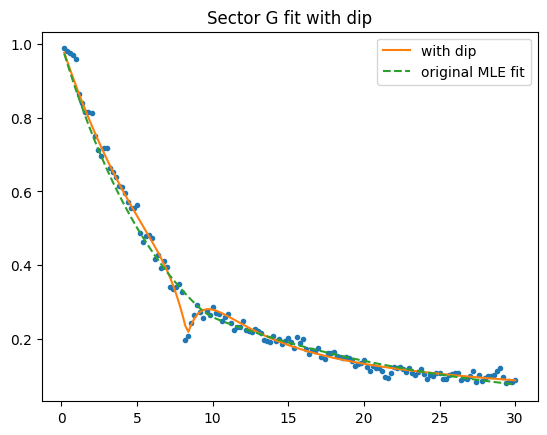

--- Sector M ---
Fitted parameters (with dip):
mu_ub: 0.09151318425809846, mu_lb: 1.0000000000014622e-05, K: 22.6154931743753, m: 9.085326617250406, t_e: 8.334093879570002, eps0: 1.8270555060185558, tau: 0.4917544361781198, lam: 0.49175443617811887
AIC with dip = 213265.79612353133 
 AIC original = 213792.9742091233
BIC with dip = 213345.96628823687 
 BIC original = 213833.05929147606


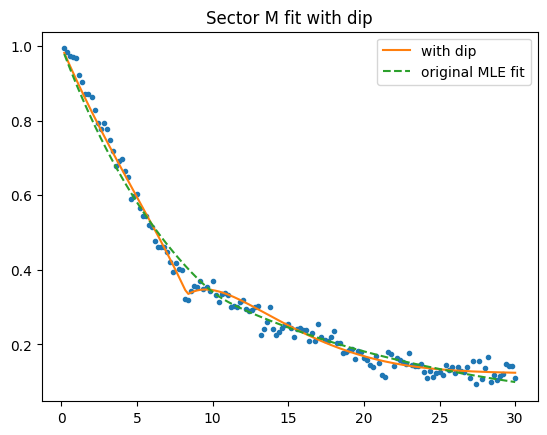

--- Sector F ---
Fitted parameters (with dip):
mu_ub: 0.07823082053137993, mu_lb: 0.07823081954302358, K: 8.861577680586363, m: 2.677382868039082, t_e: 6.641768696474266, eps0: 3.2964951390038406, tau: 2.7964265637912753, lam: 1.9567103370247885
AIC with dip = 95558.59371666133 
 AIC original = 95571.32745895388
BIC with dip = 95638.76388136687 
 BIC original = 95611.41254130665


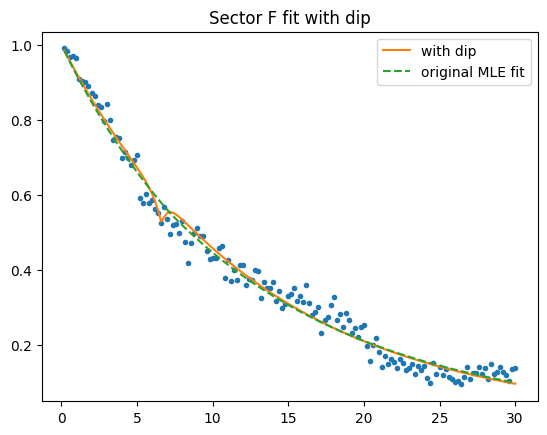

--- Sector J ---
Fitted parameters (with dip):
mu_ub: 0.12380236896447126, mu_lb: 0.05990189139824615, K: 10.730531956372207, m: 19.594967592489983, t_e: 4.606511173078112, eps0: 8.159831247722261, tau: 2.940651621350612, lam: 2.940651621350612
AIC with dip = 113665.03803974776 
 AIC original = 113961.26472763256
BIC with dip = 113745.2082044533 
 BIC original = 114001.34980998533


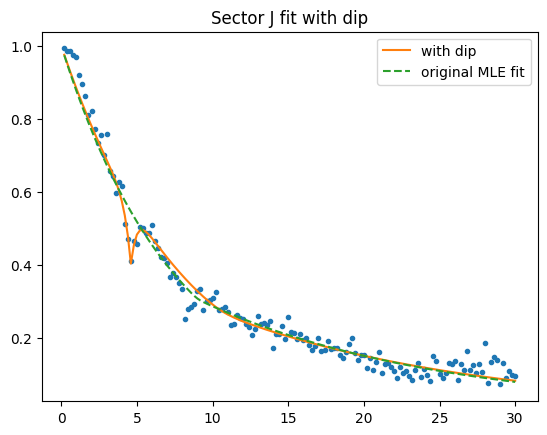

--- Sector K ---
Fitted parameters (with dip):
mu_ub: 0.06836565038328336, mu_lb: 0.006088891461297351, K: 18.83522012760923, m: 12.042671351310574, t_e: 7.9306628259233465, eps0: 1.9915464241823038, tau: 1.1726808093761625, lam: 1.1726808093753656
AIC with dip = 112391.72210524612 
 AIC original = 112433.7547534963
BIC with dip = 112471.89226995167 
 BIC original = 112473.83983584907


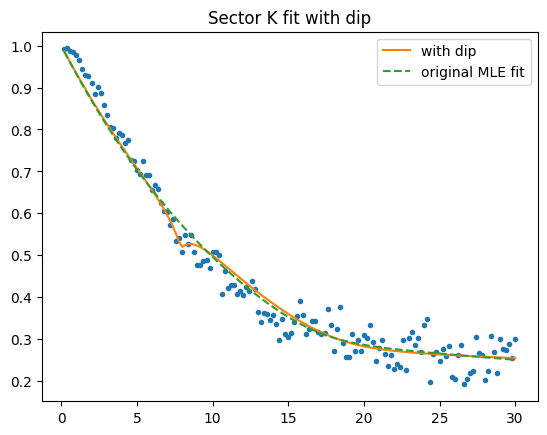

--- Sector C ---
Fitted parameters (with dip):
mu_ub: 0.07887320195805618, mu_lb: 0.05321588921418311, K: 13.451325856903493, m: 50.0, t_e: 8.354903481969055, eps0: 1.1392633322004007, tau: 0.3415577177517503, lam: 0.29564079208694954
AIC with dip = 79036.73530286804 
 AIC original = 79079.07595998689
BIC with dip = 79116.90546757358 
 BIC original = 79119.16104233966


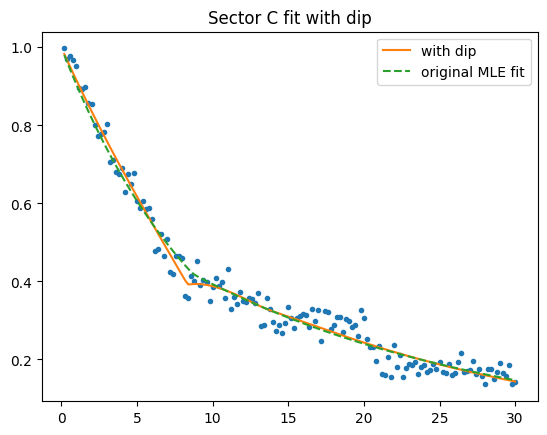

--- Sector H ---
Fitted parameters (with dip):
mu_ub: 0.09402071749646707, mu_lb: 1.0000000000001304e-05, K: 22.15992669258889, m: 6.5322781707039335, t_e: 7.26124509977692, eps0: 10.481172169899928, tau: 1.2397090799372914, lam: 0.6280954896490218
AIC with dip = 83292.34049377956 
 AIC original = 85957.70099236167
BIC with dip = 83372.5106584851 
 BIC original = 85997.78607471444


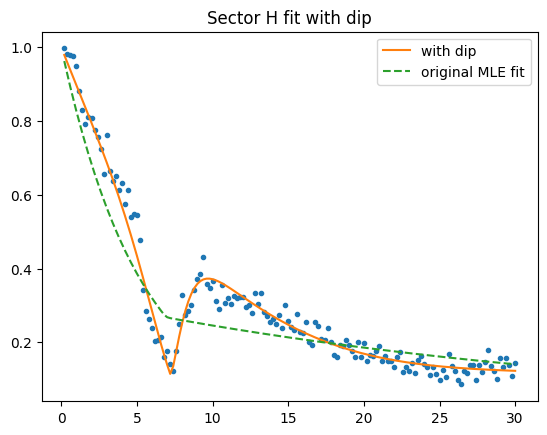

--- Sector S ---
Fitted parameters (with dip):
mu_ub: 0.13512916312691858, mu_lb: 1e-05, K: 13.611759060903983, m: 5.567292696018653, t_e: 8.305776550826934, eps0: 19.999999999169845, tau: 4.171603989279435, lam: 4.171603989279435
AIC with dip = 71396.30454515485 
 AIC original = 71512.57347341714
BIC with dip = 71476.4747098604 
 BIC original = 71552.65855576991


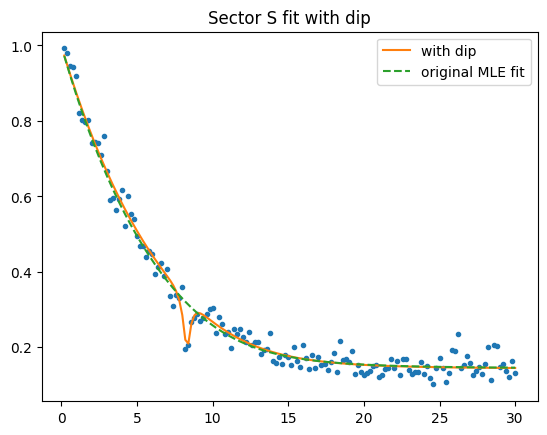

--- Sector N ---
Fitted parameters (with dip):
mu_ub: 0.10543511722076102, mu_lb: 1e-05, K: 19.756339928561527, m: 49.99999999890057, t_e: 8.382013597765164, eps0: 2.2603892537681416, tau: 1.0033079209150733, lam: 0.5624162733349949
AIC with dip = 73821.97818190404 
 AIC original = 74032.64426434244
BIC with dip = 73902.14834660958 
 BIC original = 74072.72934669521


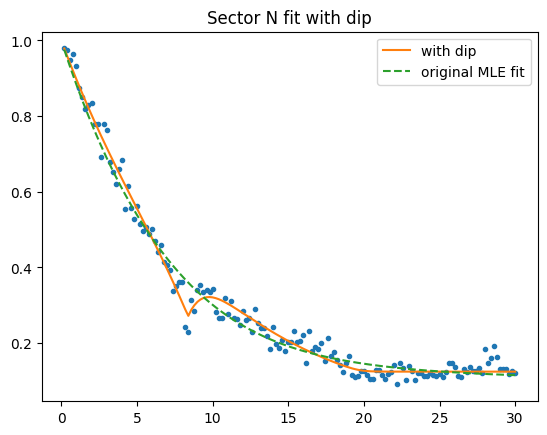

--- Sector I ---
Fitted parameters (with dip):
mu_ub: 0.12082548355987632, mu_lb: 1e-05, K: 21.23859415946881, m: 6.611737760648769, t_e: 6.29151132689797, eps0: 0.5079414902167796, tau: 0.5960212304771834, lam: 0.5960212305213041
AIC with dip = 68493.55111260401 
 AIC original = 68503.12634688056
BIC with dip = 68573.72127730955 
 BIC original = 68543.21142923333


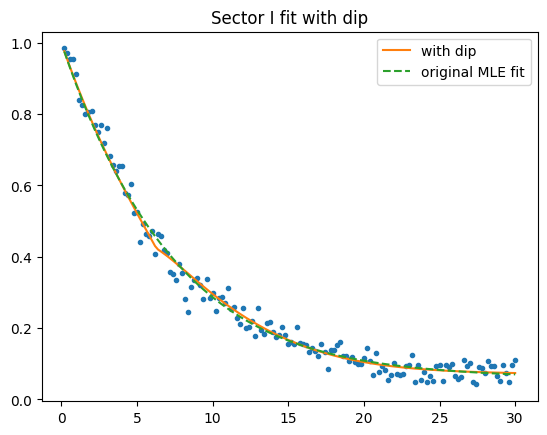

--- Sector P ---
Fitted parameters (with dip):
mu_ub: 0.09639541913439431, mu_lb: 1.0000391319502397e-05, K: 23.44265487261969, m: 49.99999898686276, t_e: 8.417080680754275, eps0: 1.5388077212931306, tau: 0.36530577698480476, lam: 0.3653057849508415
AIC with dip = 50206.3583256885 
 AIC original = 50319.80915009245
BIC with dip = 50286.52849039404 
 BIC original = 50359.89423244522


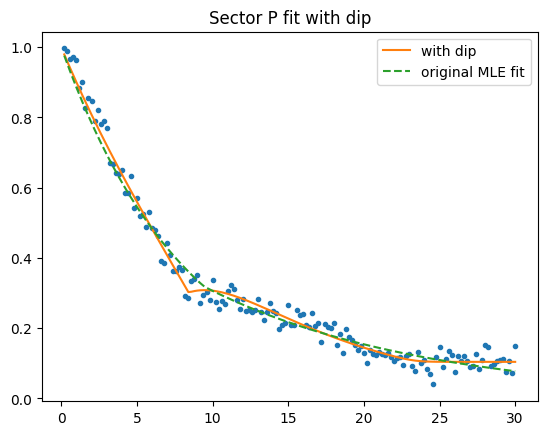

--- Sector L ---
Fitted parameters (with dip):
mu_ub: 0.07375555590082455, mu_lb: 0.07375555589464389, K: 14.800326118052075, m: 7.709529774680481, t_e: 8.39386335751012, eps0: 1.9621201021147412, tau: 4.140578550418001, lam: 1.3034765430359698
AIC with dip = 23872.851040491896 
 AIC original = 23866.308678079025
BIC with dip = 23953.021205197438 
 BIC original = 23906.393760431794


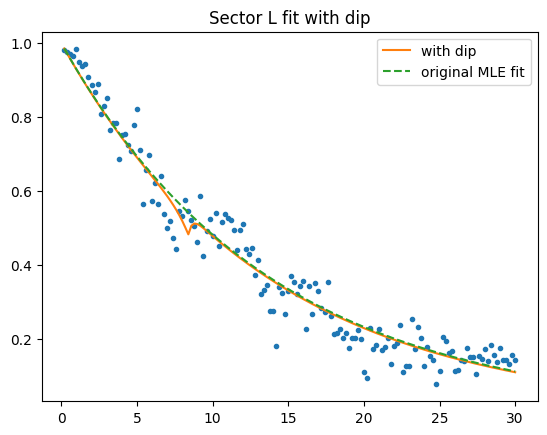

--- Sector Q ---


C:\Users\chong\AppData\Local\Temp\ipykernel_13324\3440803057.py:23: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


Fitted parameters (with dip):
mu_ub: 0.06034067842817058, mu_lb: 0.05539536953427798, K: 13.15666582358525, m: 36.45727288084492, t_e: 7.625020551480501, eps0: 1.1366838700908235, tau: 0.289940299002324, lam: 0.289940299002324
AIC with dip = 25773.484154976853 
 AIC original = 25785.16168086943
BIC with dip = 25853.654319682395 
 BIC original = 25825.2467632222


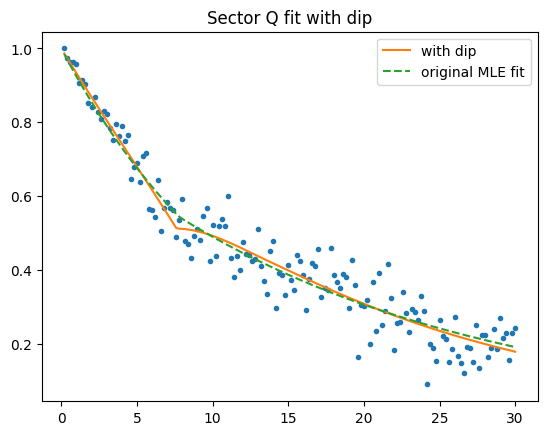

--- Sector R ---
Fitted parameters (with dip):
mu_ub: 0.12840363648840727, mu_lb: 0.08641759306173137, K: 9.441328863950961, m: 50.0, t_e: 4.565999144657748, eps0: 5.103121062476671, tau: 9.839806511292606, lam: 2.1622734344841117
AIC with dip = 15039.03347702579 
 AIC original = 15047.29190333227
BIC with dip = 15119.20364173133 
 BIC original = 15087.376985685041


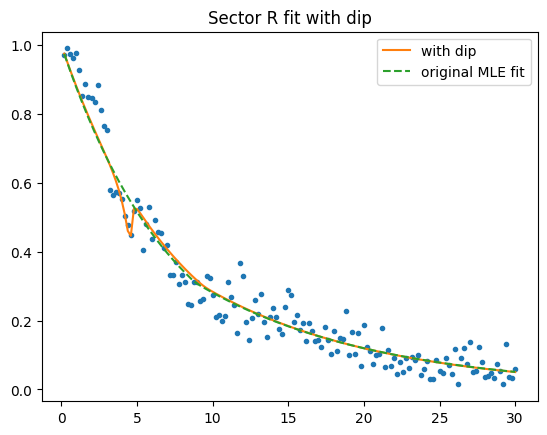

In [39]:
# test_list = ['G', 'H', 'S', 'J', 'M', 'I']
aic_dip_list = []
aic_original_list = []
bic_dip_list = []
bic_original_list = []

for sector in sector_list:
    print(f'--- Sector {sector} ---')
    aic, bic = onetail_dip_model(df_analysis, sector_params_MLE, sector)
    aic_dip_list.append(aic[0])
    aic_original_list.append(bic[1])  
    bic_dip_list.append(bic[0])
    bic_original_list.append(bic[1])

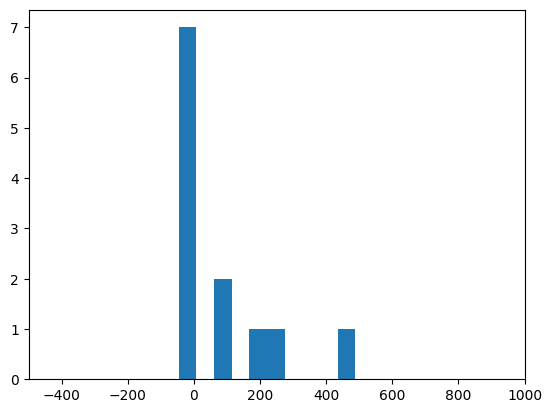

   Sector     AIC diff     BIC diff
0       G  1168.670649  1088.500485
1       M   567.263168   487.093003
2       F    52.818825   -27.351340
3       J   336.311770   256.141606
4       K    82.117731     1.947566
5       C    82.425739     2.255575
6       H  2705.445581  2625.275416
7       S   156.354011    76.183846
8       N   250.751165   170.581000
9       I    49.660317   -30.509848
10      P   153.535907    73.365742
11      L    33.542720   -46.627445
12      Q    51.762608   -28.407556
13      R    48.343509   -31.826656


In [41]:
diff_list = np.array(bic_original_list)-np.array(bic_dip_list)
plt.hist(diff_list, bins=50, label='BIC difference')
plt.xlim(-500, 1000)
plt.show()

table = pd.DataFrame({
    'Sector': sector_list,
    'AIC diff': np.array(aic_original_list) - np.array(aic_dip_list),
    'BIC diff': np.array(bic_original_list) - np.array(bic_dip_list)
})
print(table)

# J v.s. K
# S is the cut-off, exception of K

C:\Users\chong\AppData\Local\Temp\ipykernel_13324\3440803057.py:23: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m) * epsilon(s, a, eps0, tau, lam, t_e), 0, a)


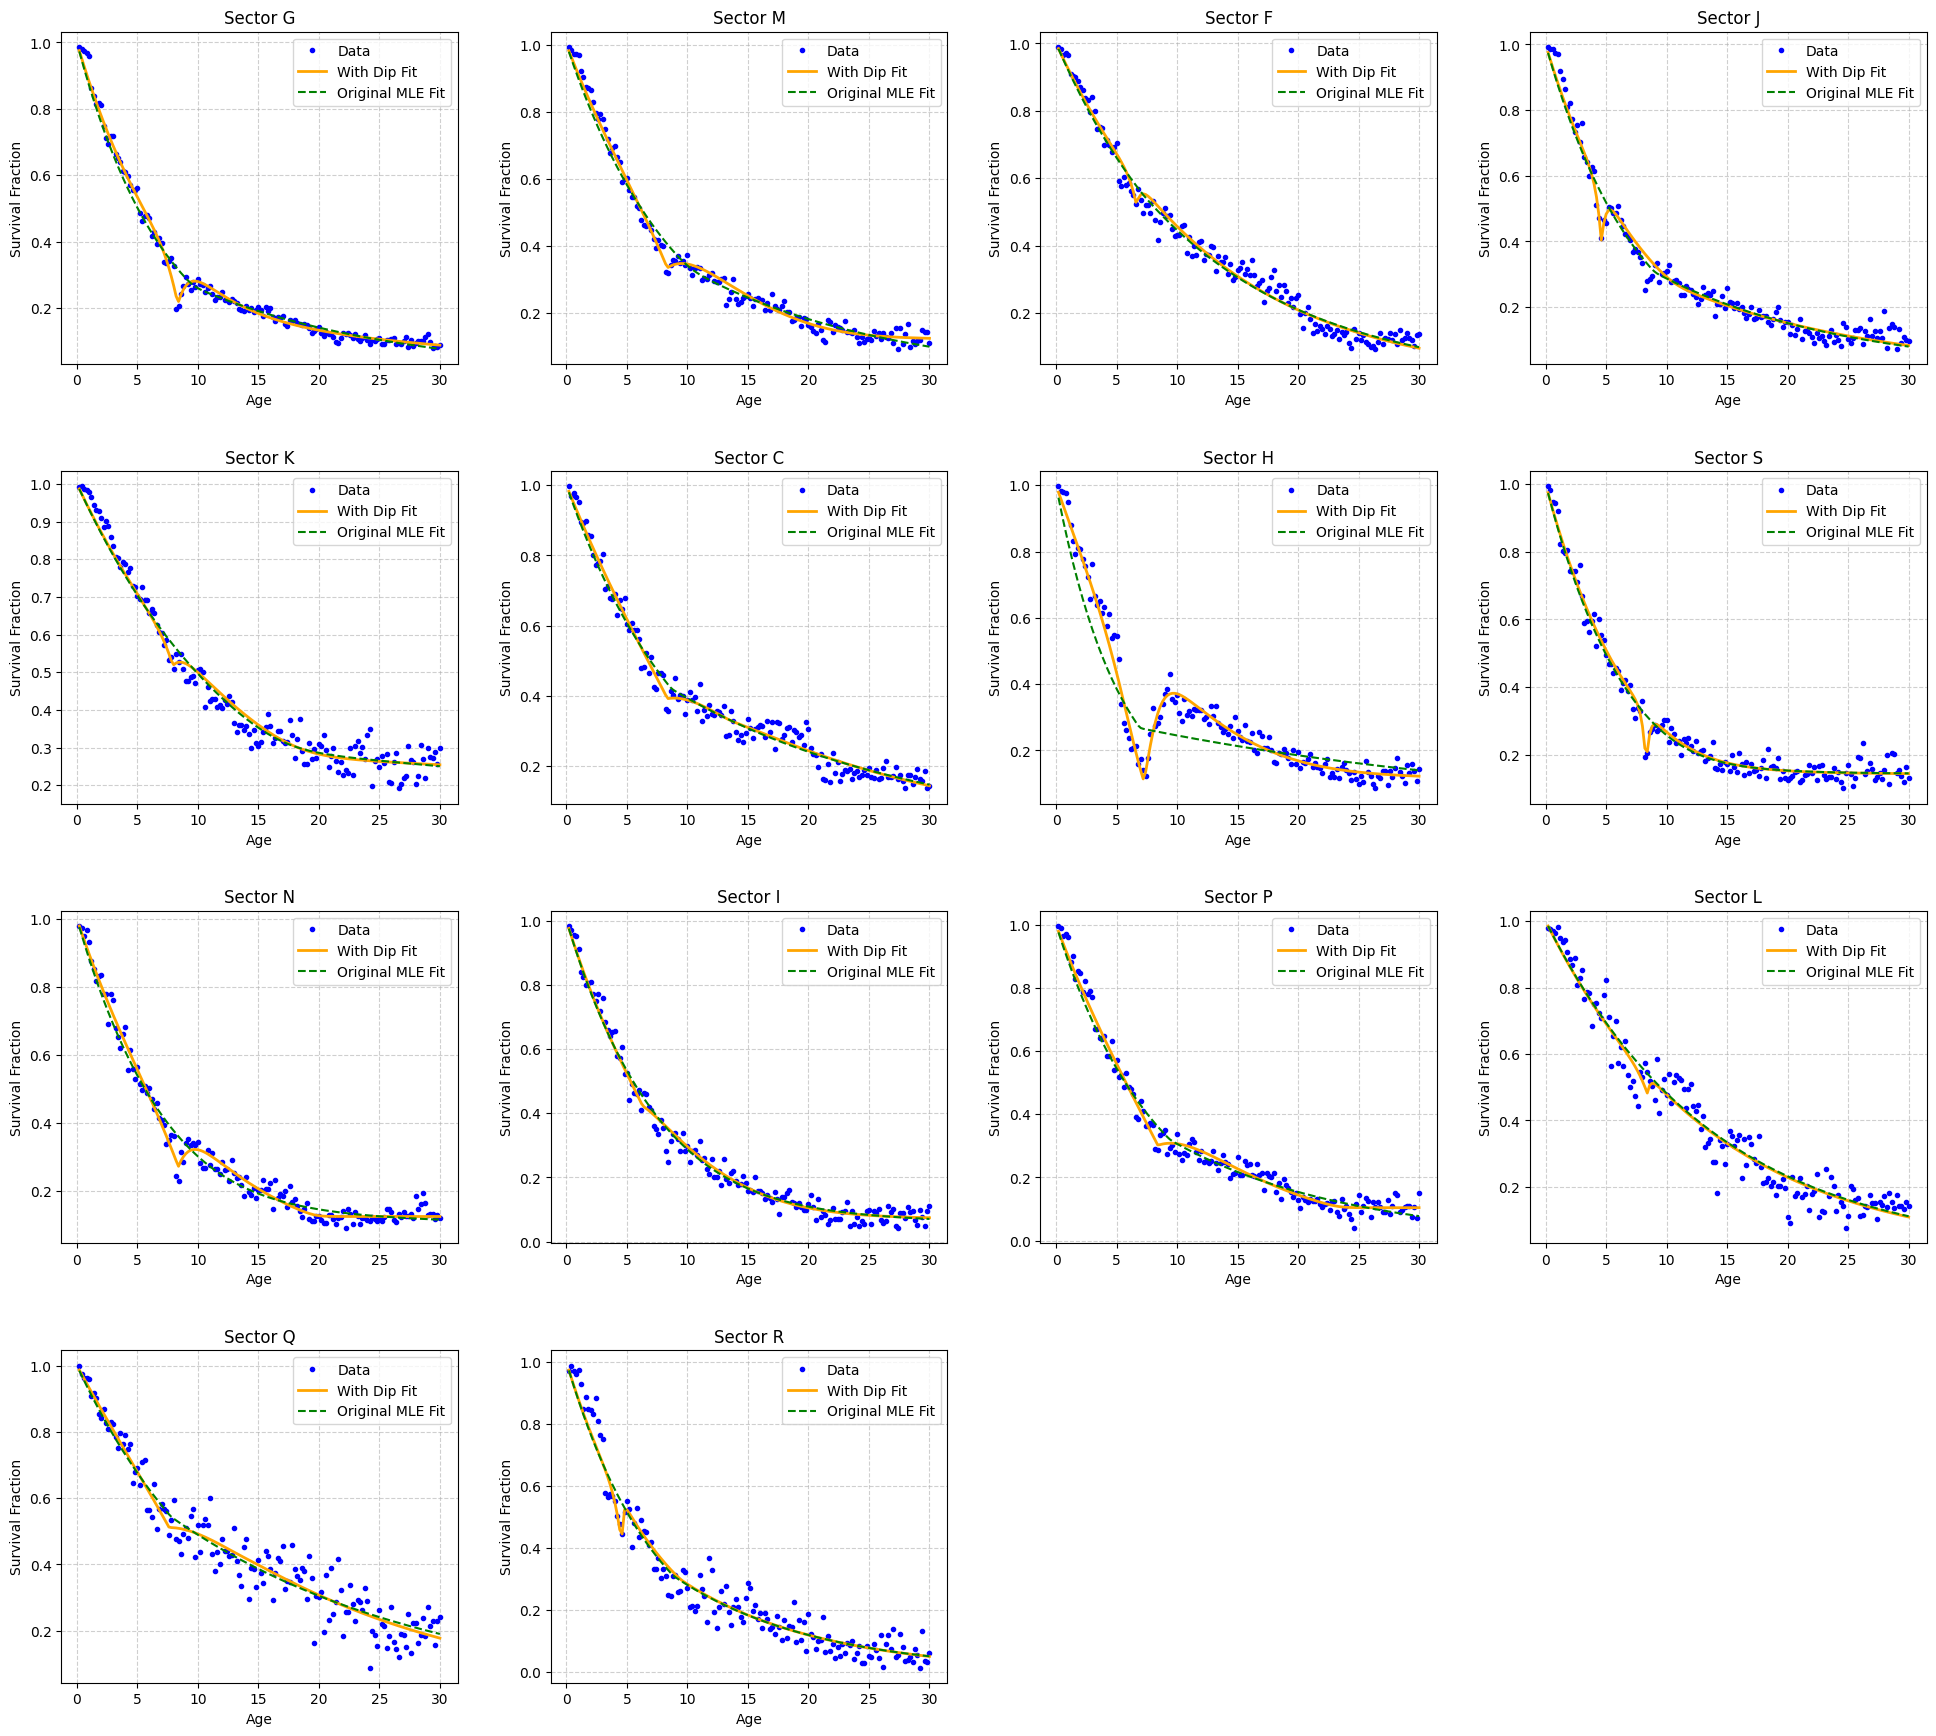

In [43]:
def plot_sectors(df_analysis, sector_params_MLE, all_sectors):
    """
    Calculates and plots the survival curve fits for all specified sectors 
    on a single figure with multiple subplots.

    Args:
        df_analysis: The DataFrame containing the survival data.
        sector_params_MLE: A dictionary containing the original MLE parameters for each sector.
        all_sectors: A list of all sector identifiers to be plotted.
    """
    # Create a grid of subplots. A 4x4 grid is suitable for 14 sectors.
    fig, axes = plt.subplots(4, 4, figsize=(20, 18))
    # Flatten the 2D array of axes to make it easier to iterate over
    axes = axes.flatten()

    for i, sector in enumerate(all_sectors):
        ax = axes[i] # Get the current subplot axis

        try:
            # --- Data Extraction and Model Fitting (from your original function) ---
            survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
            totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)

            # Define initial guess for the optimization
            initial_guess = [0.1, 0.03, 10, 5, find_dip(df_analysis, sector), 3, 1, 1]

            # Perform the MLE fit for the model with a dip
            result = mlefit_hill_with_dip(ages, survivors, totals, initial_guess)
            mu_ub, mu_lb, K, m, t_e, eps0, tau, lam = result.x

            # --- Plotting on the Subplot ---
            # Plot the raw survival data points
            ax.plot(ages, survival_fractions, 'o', markersize=3, label='Data', color='blue')
            
            # Plot the fitted model with the dip
            ax.plot(ages, model_hill_with_dip(ages, mu_ub, mu_lb, K, m, t_e, eps0, tau, lam), 
                    label='With Dip Fit', color='orange', linewidth=2)
            
            # Plot the original MLE fit without the dip
            ax.plot(ages, model_survival_curve_hill(ages, *sector_params_MLE[sector]), 
                    '--', label='Original MLE Fit', color='green')
            
            ax.set_title(f'Sector {sector}')
            ax.set_xlabel('Age')
            ax.set_ylabel('Survival Fraction')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.6)

        except Exception as e:
            # If fitting or plotting fails for a sector, print an error and leave the subplot blank
            print(f"Could not process Sector {sector}: {e}")
            ax.set_title(f'Sector {sector} - Error')
            ax.text(0.5, 0.5, 'Fit Failed', horizontalalignment='center', verticalalignment='center')


    # --- Figure Cleanup ---
    # Hide any unused subplots if the number of sectors is not a perfect square
    for j in range(len(all_sectors), len(axes)):
        axes[j].set_visible(False)

    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(pad=3.0)
    
    # Show the final combined plot
    plt.show()

plot_sectors(df_analysis, sector_params_MLE, sector_list)